- 트랜잭션 스냅샷 은 개별 트랜잭션의 특정 시점에 모든 트랜잭션이 활성화되었는지 여부에 대한 정보를 저장하는 데이터 세트.
  - 활성 트랜잭션은 진행 중이거나 아직 시작되지 않았음을 의미.

- PostgreSQL은 내부적으로 트랜잭션 스냅샷의 텍스트 표현 형식을 '100:100:'으로 정의.
  - 예를 들어 '100:100:'은 '99보다 작은 txid는 활성 상태가 아니며 100보다 크거나 같은 txid는 활성 상태'를 의미.


**내장 함수 pg_current_snapshot 및 해당 텍스트 표현 형식**

- pg_current_snapshot 함수는 현재 트랜잭션의 스냅샷을 보여줌.



```
testdb=# SELECT pg_current_snapshot();
 pg_current_snapshot
---------------------
 100:104:100,102
(1 row)
```

- txid_current_snapshot의 텍스트 표현은 'xmin:xmax:xip_list' 이며 구성 요소는 다음과 같이 설명됨.

**xmin**
- (아직 활성 상태인 가장 빠른 txid): 모든 이전 트랜잭션은 커밋되어 표시되거나 롤백되어 중단됨.

**xmax**
- (아직 할당되지 않은 첫 번째 txid): 이보다 크거나 같은 모든 txid는 스냅샷 시점에 아직 시작되지 않았으므로 표시되지 않음.

**xip_list**
- (스냅샷 당시 활성 트랜잭션 ID 목록): 목록에는 xmin과 xmax 사이의 활성 txid만 포함됨.

- 예를 들어 스냅샷 '100:104:100,102'에서 xmin은 '100', xmax는 '104', xip_list는 '100,102'.

**트랜잭션 스냅샷 표현**

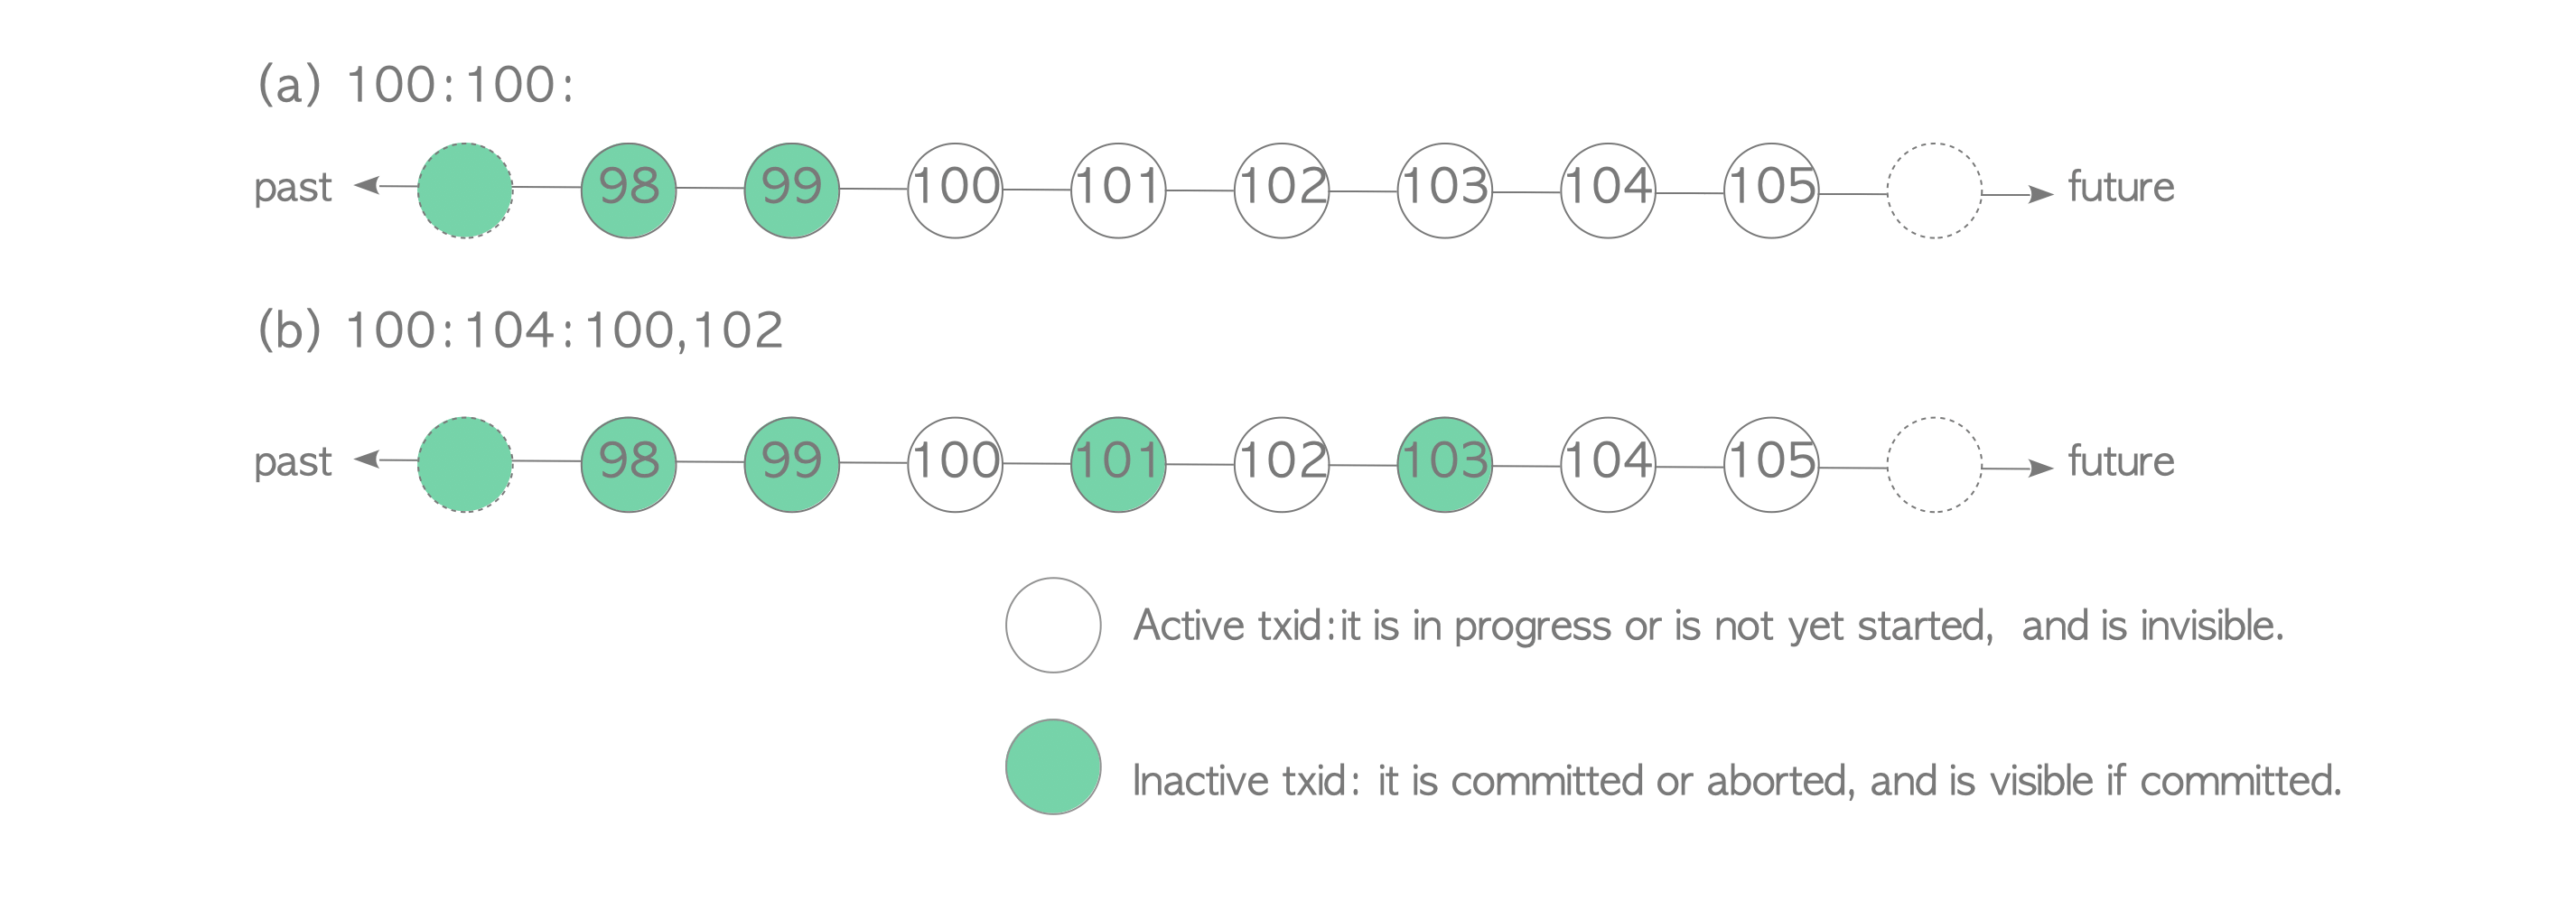

**첫 번째 예는 '100:100:'**

- xmin이 100이므로 99보다 작거나 같은 txid는 활성화 되지 않음.

- xmax가 100이므로 100보다 크거나 같은 txids가 활성화 됨.

**두 번째 예는 '100:104:100,102'**

- 99 이하의 txid는 활성화 되지 않음 .
- 104보다 크거나 같은 txid가 활성화 되어 있음 .
- txid 100 및 102는 xip 목록에 존재하므로 활성 상태 인 반면, txid 101 및 103은 활성 상태 가 아님.

<br>

- 트랜잭션 스냅샷은 트랜잭션 관리자가 제공
  - READ COMMITTED 격리 수준에서 트랜잭션은 SQL 명령이 실행될 때마다 스냅샷을 얻음.
  - 그렇지 않은 경우(REPEATABLE READ 또는 SERIALIZABLE) 트랜잭션은 첫 번째 SQL 명령이 실행될 때만 스냅샷을 가져옴.
- 획득된 트랜잭션 스냅샷은 튜플의 가시성 확인에 사용됨.


- 가시성 확인을 위해 획득한 스냅샷을 사용할 때 스냅샷의 활성 트랜잭션은 실제로 커밋되거나 중단되었더라도 진행 중인 트랜잭션으로 처리되어야 함.
  - 이 규칙은 READ COMMITTED와 REPEATABLE READ(또는 SERIALIZABLE) 간의 동작에 차이를 발생시키기 때문에 중요.

- 다음 섹션에서 그림의 특정 시나리오를 사용하여 트랜잭션 관리자와 트랜잭션을 설명.

**트랜잭션 관리자 및 트랜잭션.**

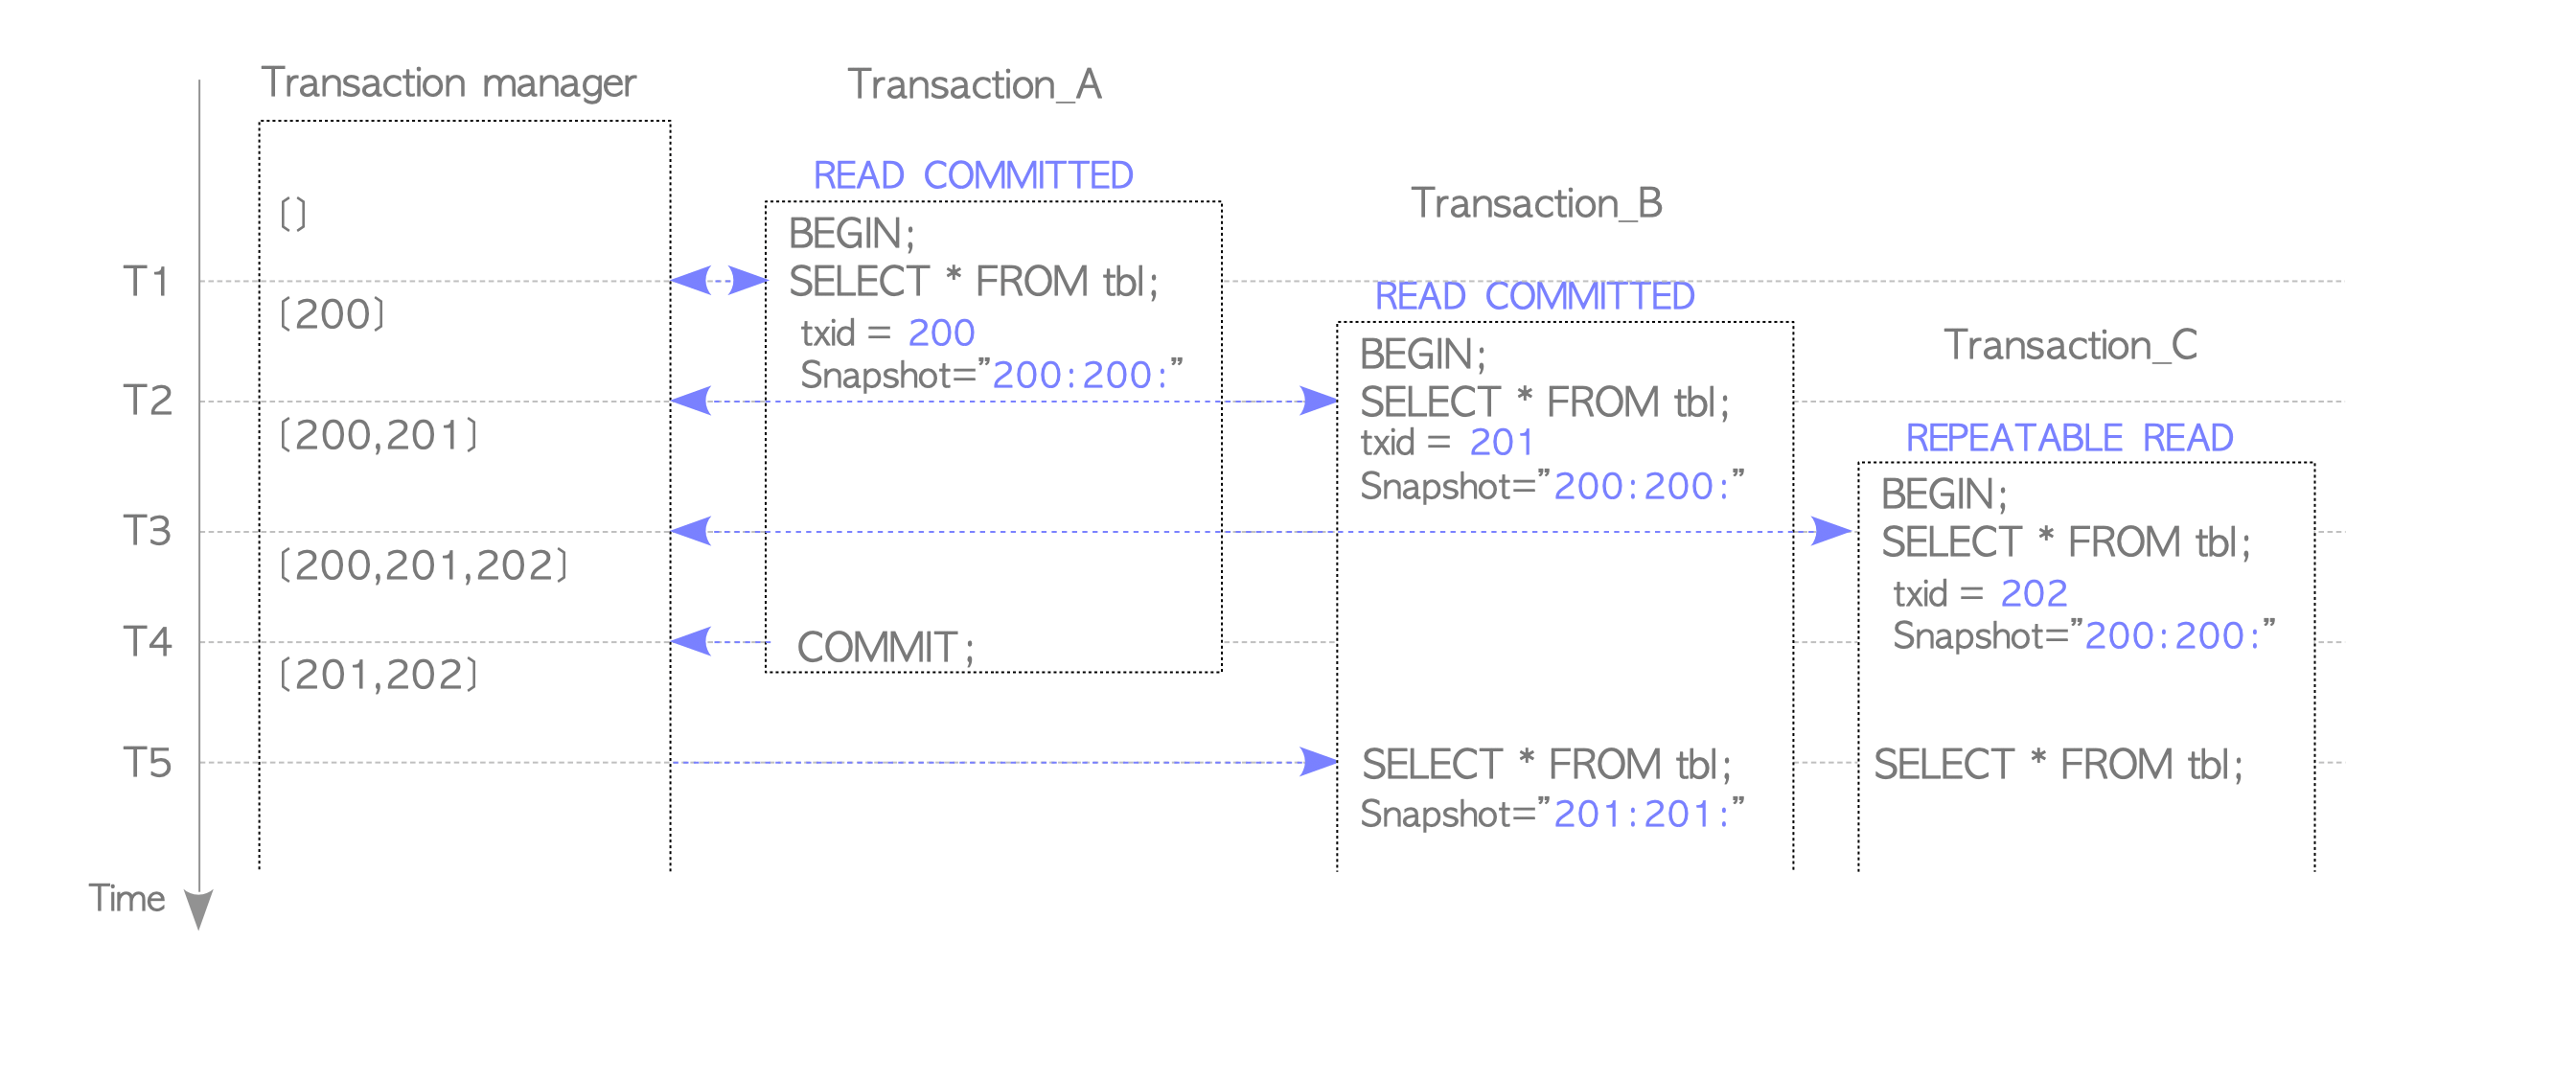

- 트랜잭션 관리자는 항상 현재 실행 중인 트랜잭션에 대한 정보를 보유.
- 세 개의 트랜잭션이 차례로 시작되고 Transaction_A와 Transaction_B의 격리 수준이 READ COMMITTED이고 Transaction_C의 격리 수준이 REPEATABLE READ라고 가정.

**T1:**
- Transaction_A가 시작되고 첫 번째 SELECT 명령을 실행.
- 첫 번째 명령을 실행하면 Transaction_A는 현재 순간의 txid와 snapshot을 요청.
- 이 시나리오에서 트랜잭션 관리자는 txid 200을 할당하고 트랜잭션 스냅샷 '200:200:'을 반환.

**T2:**
- Transaction_B가 시작되고 첫 번째 SELECT 명령을 실행
- 트랜잭션 관리자는 txid 201을 할당하고 Transaction_A(txid 200)가 진행 중이므로 트랜잭션 스냅샷 '200:200:'을 반환
- 따라서 Transaction_A는 Transaction_B에서 볼 수 없음.

**T3:**
- Transaction_C가 시작되고 첫 번째 SELECT 명령을 실행
- 트랜잭션 관리자는 txid 202를 할당하고 트랜잭션 스냅샷 '200:200:'을 반환하므로 Transaction_C에서는 Transaction_A와 Transaction_B를 볼 수 없음.

**T4:**
- Transaction_A가 커밋.
- 트랜잭션 관리자는 이 트랜잭션에 대한 정보를 제거.

**T5:**
- Transaction_B와 Transaction_C는 각각의 SELECT 명령을 실행.
- Transaction_B는 READ COMMITTED 수준이므로 트랜잭션 스냅샷이 필요.
- 이 시나리오에서는 Transaction_A(txid 200)가 커밋되었기 때문에 Transaction_B는 새 스냅샷 '201:201:'을 얻음.
  -  따라서 Transaction_A는 더 이상 Transaction_B에서 보이지 않음. Transaction_C는 REPEATABLE READ 수준에 있고 획득한 스냅샷(예: '200:200:')을 사용하므로 트랜잭션 스냅샷이 필요하지 않음.
  - 따라서 Transaction_A는 여전히 Transaction_C에서 보이지 않음